# Final
## Steve Cheney
### RBIF110



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import pubchempy as pcp

import requests
import time

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

## Data Setup

In [2]:
alz_library_file = "Drugs.csv"
try:
    alz_lib = pd.read_csv(alz_library_file, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    alz_lib = pd.read_csv(alz_library_file, sep=",", encoding="latin-1")

alz_lib = alz_lib.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']).rename(columns={"Canonical SMILES": "SMILES"})

##########################################################

def get_smiles(pubchem_cid):
    try:
        compound = pcp.Compound.from_cid(pubchem_cid)  # Fetch compound from CID
        return compound.isomeric_smiles  # Extract SMILES string
    except:
        return None  # Return None if CID is invalid or not found

cnss_library_file = "cns_simulants.csv"
try:
    cnss_lib = pd.read_csv(cnss_library_file, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    cnss_lib = pd.read_csv(cnss_library_file, sep=",", encoding="latin-1")

cnss_lib["SMILES"] = cnss_lib["PubChem CID"].apply(get_smiles)

cnss_lib = cnss_lib.drop_duplicates(subset=["PubChem CID"])
cnss_lib = cnss_lib.reset_index(drop=True)

##########################################################

rep_library_file = "repurposing_samples.txt"
try:
    rep_lib = pd.read_csv(rep_library_file, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    rep_lib = pd.read_csv(rep_library_file, sep="\t", encoding="latin-1")

rep_lib.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,0,98.90,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,0,95.80,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,448055.0,NaN


In [11]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version.

    Args:
        - smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle missing values or non-string input
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None

    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:  # Check for invalid SMILES
        return None
    
    try:
        # Choose the largest fragment if the molecule has multiple components
        largest_Fragment = rdMolStandardize.LargestFragmentChooser()
        mol = largest_Fragment.choose(mol)  

        # Generate canonical SMILES
        canonical_smiles = Chem.MolToSmiles(mol, canonical=True)

        return canonical_smiles

    except Exception as e:
        print(f"Error processing SMILES: {smiles}, Error: {e}")
        return None

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset
    
def smiles_to_sdf(dataframe, smiles_col, output_sdf):
    # Create a Pybel molecule object for each SMILES
    molecules = []
    for idx, row in dataframe.iterrows():
        smiles = row[smiles_col]
        mol = pb.readstring("smi", smiles)  # Read the SMILES string
        mol.title = row["name"]  # Set molecule name

        # Add custom properties (e.g., p_np) to the molecule
        if "p_np" in row:
            mol.data["p_np"] = row["p_np"]  # Add the p_np property

        molecules.append(mol)
    
    # Write to an SDF file
    with pb.Outputfile("sdf", output_sdf, overwrite=True) as sdf_file:
        for mol in molecules:
            sdf_file.write(mol)

def extract_properties_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    data = []
    for mol in supplier:
        if mol is not None:  # Ensure valid molecule
            props = {
                "name": mol.GetProp("_Name"),
                "p_np": mol.GetProp("p_np") if mol.HasProp("p_np") else None,
                "Molecular_Weight": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "H_Bond_Donors": Descriptors.NumHDonors(mol),
                "H_Bond_Acceptors": Descriptors.NumHAcceptors(mol),
                "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
                "TPSA": Descriptors.TPSA(mol),
            }
            data.append(props)
    return pd.DataFrame(data)

def calculate_similarity(df, query_smiles):
    """
    Calculate Tanimoto similarity between a query SMILES and a dataframe of molecules

    Args:
        - df: pd.Dataframe, DataFrame containing a 'SMILES' column
        - query_smiles: str, Query molecule in SMILES format

    Returns:
        pd.DataFrame
    """

    df_copy = df.copy()

    # Convert query SMILES to RDKit Mol object
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        raise ValueError("Invalid SMILES string provided for query.")

    # Generate fingerprint for query molecule
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=1024)

    # Compute similarity scores
    similarity_scores = [
        (DataStructs.TanimotoSimilarity(query_fp, AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
         if mol is not None else None)
        for mol in df_copy['standardized_mol']
    ]

    # Add similarity scores to dataframe
    df_copy['similarity'] = similarity_scores
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)

    return df_sorted

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None
    
def dataframe_setup(df, smiles_col, mol_col):
    # Clean the data to ignore any NaN smiles values and subset data if needed
    df = clean_df_and_create_mol_col(df, smiles_col, mol_col)
    df['standardized_mol'] = df[smiles_col].apply(get_standard_mol)
    df['canonical_smiles'] = df[smiles_col].apply(standardize_smiles)
    df['fingerprint'] = df['standardized_mol'].apply(get_fingerprint)

    descriptor_data = df["standardized_mol"].apply(calculate_descriptors)

    filtered_data = [d for d in descriptor_data if d is not None]
    descriptor_df = pd.DataFrame(filtered_data)
    df = pd.concat([df, descriptor_df], axis=1)

    df = df.dropna(subset=['standardized_mol', 'canonical_smiles', 'fingerprint', "Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"])
    df = df[(df['standardized_mol'] != '') & (df['canonical_smiles'] != '') & (df['fingerprint'] != '')]
    
    print(df.shape)
    print(df.head())
    return df


In [12]:
alz_lib = dataframe_setup(alz_lib, 'SMILES', 'mol')
cnss_lib = dataframe_setup(cnss_lib, 'SMILES', 'mol')
rep_lib = dataframe_setup(rep_lib, 'smiles', 'mol')

(1090, 30)
  IPAD_DB_ID              Name            Targeting-protein  \
0     D00001         Donepezil               5-HT6 receptor   
1     D00002         Donepezil  Acetylcholinesterase (AChE)   
2     D00003  Rolitetracycline  Aβ42 oligomers  and fibrils   
3     D00004      Daunomycinol                       Aβ1-40   
4     D00005         Donepezil                       Aβ1-42   

                     Research models  \
0             In silico and in vitro   
1             In silico and in vitro   
2                           In vitro   
3  IMR32 human neuroblastoma cells,    
4             In silico and in vitro   

                                           Ref. Link Molecular Formula  \
0       https://doi.org/10.1021/acschemneuro.8b00024         C24H29NO3   
1       https://doi.org/10.1021/acschemneuro.8b00024         C24H29NO3   
2             https://doi.org/10.1074/jbc.M608207200        C27H33N3O8   
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...        C27H31NO10   

In [9]:
def plot_property_distributions(df,id):
    """
    Generate jitter plots for the distribution of selected molecular properties
    """
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, prop in enumerate(properties):
        sns.stripplot(x=id, y=prop, data=df, jitter=True, alpha=0.6, color="blue", ax=axes[i])        
        axes[i].set_xticks([])  # Remove x-axis labels
        axes[i].set_title(f"Distribution of {prop}")
        axes[i].set_ylabel(prop)
        axes[i].set_xlabel("")

    plt.tight_layout()
    plt.show()

#plot_property_distributions(alz_lib, id="IPAD_DB_ID")
#plot_property_distributions(cnss_lib, id="PubChem CID")
#plot_property_distributions(rep_lib, id="broad_id")


s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


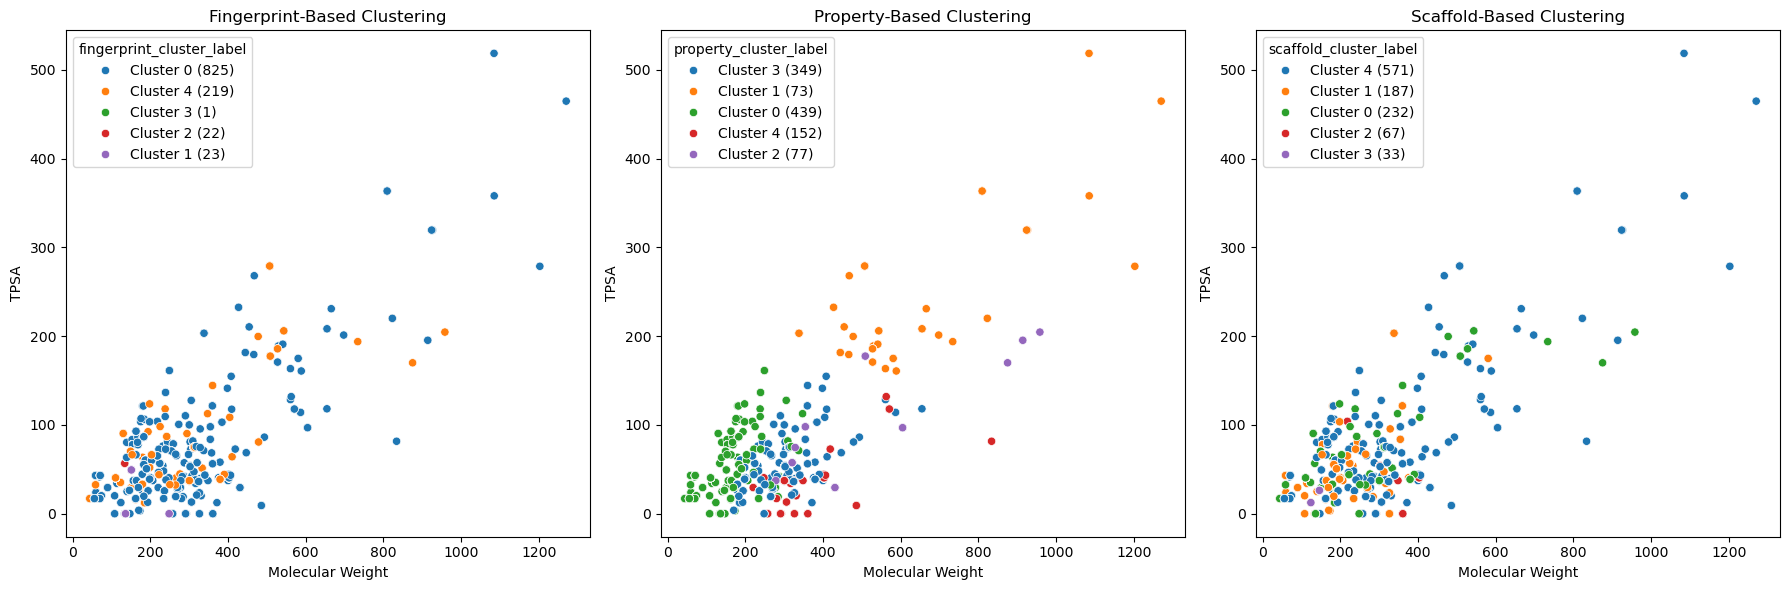

s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


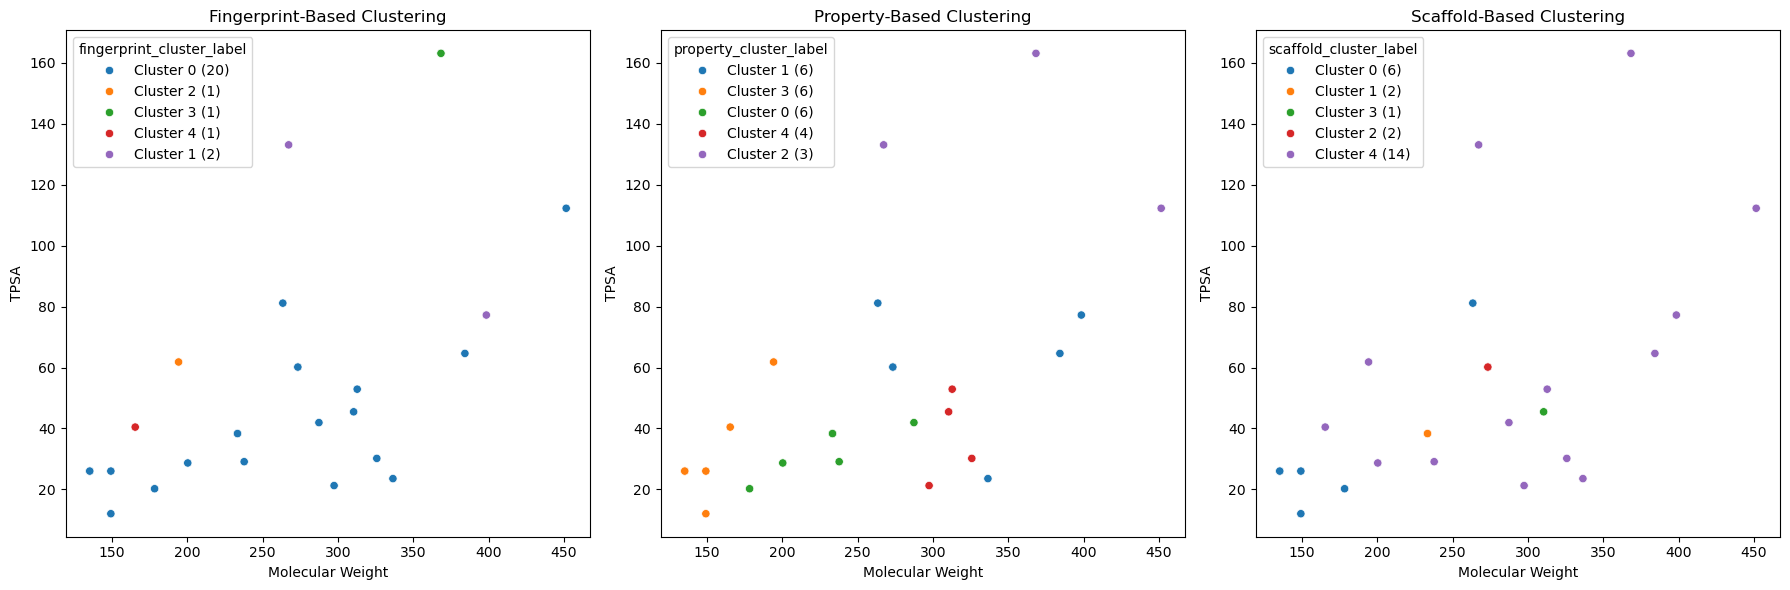

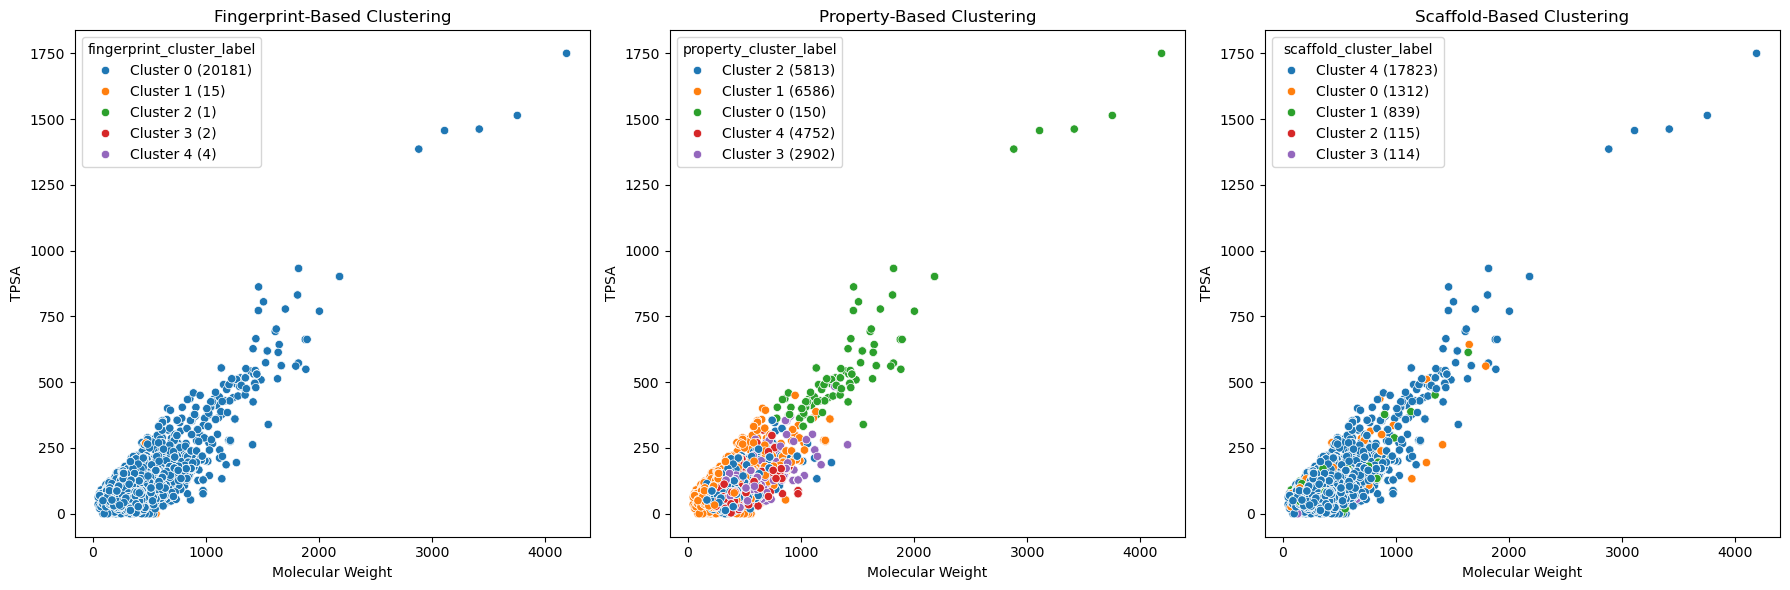

In [22]:
def cluster_by_fingerprint(df, n_clusters=5):
    """Hierarchical clustering based on Tanimoto similarity."""
    
    # Remove molecules with missing fingerprints
    df = df[df['fingerprint'].notna()].copy()
    fingerprints = df['fingerprint'].tolist()
    num_mols = len(fingerprints)

    if num_mols == 0:
        raise ValueError("No valid fingerprints available for clustering!")

    # Compute Tanimoto similarity matrix
    similarity_matrix = np.zeros((num_mols, num_mols))
    for i in range(num_mols):
        for j in range(i, num_mols):
            if fingerprints[i] is not None and fingerprints[j] is not None:
                sim = Chem.DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            else:
                sim = 0  # Default similarity for None cases
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance

    # Use metric instead of affinity
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    df['fingerprint_cluster'] = clustering.fit_predict(distance_matrix)
    return df


def cluster_by_properties(df, n_clusters=5):
    """K-means clustering on normalized molecular properties."""
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
    scaler = MinMaxScaler()
    normalized_props = scaler.fit_transform(df[properties])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['property_cluster'] = kmeans.fit_predict(normalized_props)
    return df

def get_murcko_scaffold(mol):
    """Extract Murcko scaffold."""
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol) if mol else None

def cluster_by_scaffold(df, n_scaff=4):
    """Clusters molecules by Murcko scaffold, grouping common scaffolds separately."""
    df['scaffold'] = df['standardized_mol'].apply(get_murcko_scaffold)
    scaffold_counts = Counter(df['scaffold'].dropna())
    top_scaffolds = [scaffold for scaffold, count in scaffold_counts.most_common(n_scaff)]  # Top n scaffolds

    def assign_scaffold_cluster(scaffold):
        return top_scaffolds.index(scaffold) if scaffold in top_scaffolds else len(top_scaffolds)  # Assign 'other'

    df['scaffold_cluster'] = df['scaffold'].apply(assign_scaffold_cluster)
    return df

def main_clustering_pipeline(df, n_clust=5):
    """Runs all clustering methods, computes similarity scores, and visualizes results."""
    df = cluster_by_fingerprint(df, n_clust)
    df = cluster_by_properties(df, n_clust)
    df = cluster_by_scaffold(df, n_clust-1)

    # Plot clustering results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    cluster_types = ['fingerprint_cluster', 'property_cluster', 'scaffold_cluster']
    titles = ["Fingerprint-Based Clustering", "Property-Based Clustering", "Scaffold-Based Clustering"]

    for i, cluster_col in enumerate(cluster_types):
        # Count occurrences of each cluster
        cluster_counts = df[cluster_col].value_counts().to_dict()
        # Rename clusters
        df[f"{cluster_col}_label"] = df[cluster_col].apply(
            lambda x: f"Cluster {x} ({cluster_counts[x]})"
        )

        df = df.loc[:, ~df.columns.duplicated()]

        sns.scatterplot(
            x=df['Molecular_Weight'], 
            y=df['TPSA'], 
            hue=df[f"{cluster_col}_label"], 
            palette="tab10", 
            ax=axes[i]
        )

        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Molecular Weight")
        axes[i].set_ylabel("TPSA")

    plt.tight_layout()
    plt.show()
    
    return df

alz_cluster = main_clustering_pipeline(alz_lib, n_clust=5)
cnss_cluster = main_clustering_pipeline(cnss_lib, n_clust=5)
cnss_cluster = main_clustering_pipeline(rep_lib, n_clust=5)



In [ ]:
neg_drugs_sampled = pd.read_csv("neg_drugs_with_smiles_sampled.csv")
neg_drugs_sampled.head()

,drug_name,drug_id,ind_name,ind_id,NCT,status,phase,DetailedStatus,SMILES
0,Prednisolone,DB00860,Tendinitis,C0039503,NaN,Approved,NaN,NaN,C[C@]12C[C@@H]([C@H]3[C@H]([C@@H]1CC[C@@]2(C(=...
1,Cortisone acetate,DB01380,Tendinitis,C0039503,NaN,Approved,NaN,NaN,CC(=O)OCC(=O)[C@]1(CC[C@@H]2[C@@]1(CC(=O)[C@H]...
2,Itraconazole,DB01167,Aspergillosis,C0004030,NaN,Approved,NaN,NaN,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...
3,Empagliflozin,DB09038,"Diabetes Mellitus, Non-Insulin-Dependent",C0011860,NaN,Approved,NaN,NaN,C1COC[C@H]1OC2=CC=C(C=C2)CC3=C(C=CC(=C3)[C@H]4...
4,Simvastatin,DB00641,Hyperlipoproteinemia Type III,C0020479,NaN,Approved,NaN,NaN,CCC(C)(C)C(=O)O[C@H]1C[C@H](C=C2[C@H]1[C@H]([C...


In [ ]:
# Clean the data to ignore any NaN smiles values and subset data if needed
neg_drugs_sampled = clean_df_and_create_mol_col(neg_drugs_sampled, 'SMILES', 'mol')
neg_drugs_sampled['standardized_mol'] = neg_drugs_sampled['SMILES'].apply(get_standard_mol)
neg_drugs_sampled['fingerprint'] = neg_drugs_sampled['standardized_mol'].apply(get_fingerprint)

descriptor_data = neg_drugs_sampled["standardized_mol"].apply(calculate_descriptors)

filtered_data = [d for d in descriptor_data if d is not None]
descriptor_df = pd.DataFrame(filtered_data)
neg_drugs_sampled = pd.concat([neg_drugs_sampled, descriptor_df], axis=1)
print(neg_drugs_sampled.shape)
neg_drugs_sampled.head()

(458, 17)


,drug_name,drug_id,ind_name,ind_id,NCT,status,phase,DetailedStatus,SMILES,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
0,Prednisolone,DB00860,Tendinitis,C0039503,NaN,Approved,NaN,NaN,C[C@]12C[C@@H]([C@H]3[C@H]([C@@H]1CC[C@@]2(C(=...,<rdkit.Chem.rdchem.Mol object at 0x0000014F25F...,<rdkit.Chem.rdchem.Mol object at 0x0000014F297...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",360.450,2,0,1.5576,94.83
1,Cortisone acetate,DB01380,Tendinitis,C0039503,NaN,Approved,NaN,NaN,CC(=O)OCC(=O)[C@]1(CC[C@@H]2[C@@]1(CC(=O)[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x0000014F25F...,<rdkit.Chem.rdchem.Mol object at 0x0000014F297...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",402.487,3,0,2.5606,97.74
2,Itraconazole,DB01167,Aspergillosis,C0004030,NaN,Approved,NaN,NaN,CCC(C)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=...,<rdkit.Chem.rdchem.Mol object at 0x0000014F25E...,<rdkit.Chem.rdchem.Mol object at 0x0000014F297...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",705.647,11,5,5.5773,104.70
3,Empagliflozin,DB09038,"Diabetes Mellitus, Non-Insulin-Dependent",C0011860,NaN,Approved,NaN,NaN,C1COC[C@H]1OC2=CC=C(C=C2)CC3=C(C=CC(=C3)[C@H]4...,<rdkit.Chem.rdchem.Mol object at 0x0000014F25E...,<rdkit.Chem.rdchem.Mol object at 0x0000014F297...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",450.915,6,2,1.6134,108.61
4,Simvastatin,DB00641,Hyperlipoproteinemia Type III,C0020479,NaN,Approved,NaN,NaN,CCC(C)(C)C(=O)O[C@H]1C[C@H](C=C2[C@H]1[C@H]([C...,<rdkit.Chem.rdchem.Mol object at 0x0000014F25E...,<rdkit.Chem.rdchem.Mol object at 0x0000014F297...,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",418.574,6,0,4.5856,72.83


## Modeling

In [ ]:
# Define feature columns (excluding fingerprints for now)
feature_columns = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]

# Label Alzheimer's drugs as 1
alz_df["label"] = 1

# Label negative drugs as 0
neg_drugs_sampled["label"] = 0

# Merge both datasets
combined_df = pd.concat([alz_df, neg_drugs_sampled], ignore_index=True)

# Extract features and labels
X_combined = combined_df[feature_columns].values
y_combined = combined_df["label"].values

# Standardize numerical features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

In [ ]:
# Perform cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(rf_model, X_combined_scaled, y_combined, cv=kf, scoring='accuracy')

print("Cross-validation accuracy scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))


Cross-validation accuracy scores: [0.89285714 0.87987013 0.9025974  0.90584416 0.90228013]
Mean cross-validation accuracy: 0.8966897922923982


In [ ]:
# Extract CNS drug features
X_cns = cns_df[feature_columns].values

# Standardize using the same scaler
X_cns_scaled = scaler.transform(X_cns)

# Predict Alzheimer's suitability for CNS drugs
cns_predictions = rf_model.fit(X_combined_scaled, y_combined).predict(X_cns_scaled)

# Add predictions to CNS dataframe
cns_df["Predicted_Alzheimers_Suitability"] = cns_predictions

# Filter repurposable CNS drugs
cns_repurposable = cns_df[cns_df["Predicted_Alzheimers_Suitability"] == 1]

# Save results
cns_repurposable.to_csv("cns_repurposable_candidates.csv", index=False)

print("Number of repurposable CNS drugs:", len(cns_repurposable))


Number of repurposable CNS drugs: 12


In [ ]:
importances = rf_model.feature_importances_
sorted_features = sorted(zip(importances, feature_columns), reverse=True)
print("Feature Importance:", sorted_features)


Feature Importance: [(0.2970564283841093, 'Molecular_Weight'), (0.28039206945853756, 'TPSA'), (0.23010115176608484, 'ClogP'), (0.13190436465861435, 'Rotatable_Bonds'), (0.06054598573265399, 'Aromatic_Bonds')]


In [ ]:
# Show repurposable CNS drugs
print("Repurposable CNS Drugs:")
print(cns_repurposable[["Drug Name", "PubChem CID", "SMILES"]].head(10))

print()
# Show example Alzheimer's drugs
alz_sample = alz_df.sample(n=10, random_state=42)
print("Sample Alzheimer's Drugs:")
print(alz_sample[["Name", "IPAD_DB_ID", "SMILES"]])


Repurposable CNS Drugs:
   Drug Name  PubChem CID                                             SMILES
1   Adipex-P       4771.0                               CC(C)(CC1=CC=CC=C1)N
2   Adderall       3007.0                                  CC(CC1=CC=CC=C1)N
3   Adderall       5826.0                             C[C@@H](CC1=CC=CC=C1)N
4   Concerta       4158.0                      COC(=O)C(C1CCCCN1)C2=CC=CC=C2
5    Nuvigil    9926699.0  CC(C)N1C=C2C[C@@H]3C(=C[C@H](CN3C)C(=O)O)C4=C2...
6   Provigil       4236.0            C1=CC=C(C=C1)C(C2=CC=CC=C2)S(=O)CC(=O)N
7    Focalin     154101.0             COC(=O)[C@@H]([C@H]1CCCCN1)C2=CC=CC=C2
8    Desoxyn       1206.0                                 CC(CC1=CC=CC=C1)NC
13  Ketamine       3821.0                        CNC1(CCCCC1=O)C2=CC=CC=C2Cl
16  Fentanyl       3345.0       CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3

Sample Alzheimer's Drugs:
                                                Name IPAD_DB_ID  \
524                2,4,5,2',4',5'-h

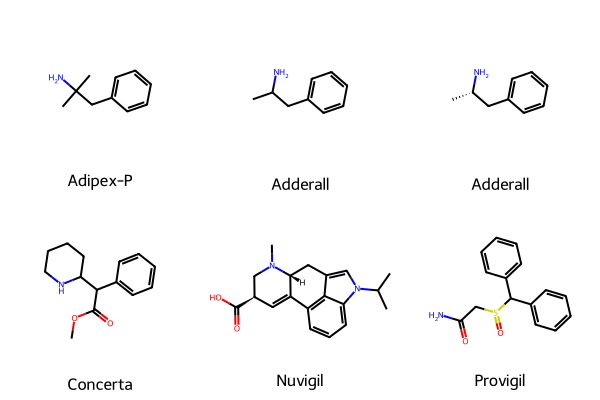

In [ ]:
# Display CNS repurposable molecules
Draw.MolsToGridImage(cns_repurposable["standardized_mol"].head(6), molsPerRow=3, subImgSize=(200,200), legends=cns_repurposable["Drug Name"].head(6).tolist())

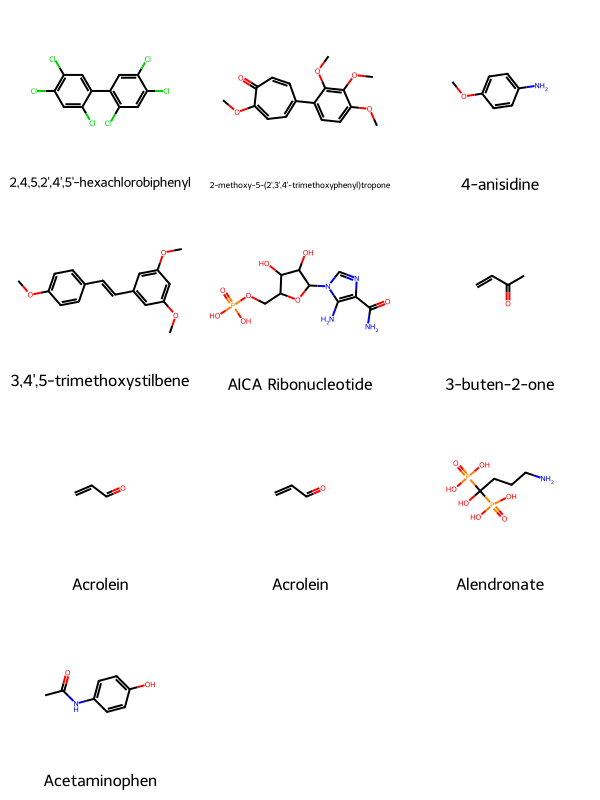

In [ ]:
# Display Alzheimer's drugs molecules
Draw.MolsToGridImage(alz_sample["standardized_mol"], molsPerRow=3, subImgSize=(200,200), legends=alz_sample["Name"].tolist())

In [ ]:
cns_repurposable.head()

,Drug Name,Generic Name,PubChem CID,SMILES,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,fingerprint_cluster,property_cluster,scaffold,scaffold_cluster,fingerprint_cluster_label,property_cluster_label,scaffold_cluster_label,Predicted_Alzheimers_Suitability
1,Adipex-P,phentermine,4771.0,CC(C)(CC1=CC=CC=C1)N,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",149.237,2.0,1.0,1.9664,26.02,0,1,c1ccccc1,0,Cluster 0 (16),Cluster 1 (10),Cluster 0 (6),1
2,Adderall,amphetamine,3007.0,CC(CC1=CC=CC=C1)N,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",135.210,2.0,1.0,1.5763,26.02,0,1,c1ccccc1,0,Cluster 0 (16),Cluster 1 (10),Cluster 0 (6),1
3,Adderall,dextroamphetamine,5826.0,C[C@@H](CC1=CC=CC=C1)N,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",135.210,2.0,1.0,1.5763,26.02,0,1,c1ccccc1,0,Cluster 0 (16),Cluster 1 (10),Cluster 0 (6),1
4,Concerta,methylphenidate,4158.0,COC(=O)C(C1CCCCN1)C2=CC=CC=C2,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",233.311,3.0,1.0,2.0853,38.33,0,1,c1ccc(CC2CCCCN2)cc1,1,Cluster 0 (16),Cluster 1 (10),Cluster 1 (2),1
5,Nuvigil,armodafinil,9926699.0,CC(C)N1C=C2C[C@@H]3C(=C[C@H](CN3C)C(=O)O)C4=C2...,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",310.397,2.0,2.0,3.1765,45.47,0,2,C1=C2c3cccc4[nH]cc(c34)CC2NCC1,3,Cluster 0 (16),Cluster 2 (4),Cluster 3 (1),1


In [ ]:
def compute_tanimoto(fp1, fp2):
    return DataStructs.FingerprintSimilarity(fp1, fp2)

# Extract relevant columns from dataframes
cns_fingerprints = cns_repurposable[['Drug Name', 'fingerprint', 'standardized_mol', 'SMILES']]
alz_fingerprints = alz_sample[['Name', 'fingerprint', 'standardized_mol', 'SMILES']]

# List to store similarity results
similarity_results = []

# Iterate over each drug in cns_repurposable
for _, cns_row in cns_fingerprints.iterrows():
    cns_drug = cns_row['Drug Name']
    cns_fp = cns_row['fingerprint']
    cns_mol = cns_row['standardized_mol']
    cns_smiles = cns_row['SMILES']

    # Find the most similar drug in alz_sample
    best_match = None
    best_similarity = 0
    best_match_mol = None

    for _, alz_row in alz_fingerprints.iterrows():
        alz_drug = alz_row['Name']
        alz_fp = alz_row['fingerprint']
        alz_mol = alz_row['standardized_mol']
        alz_smiles = alz_row['SMILES']

        similarity = compute_tanimoto(cns_fp, alz_fp)

        if similarity > best_similarity:
            best_similarity = similarity
            best_match = alz_drug
            best_match_mol = alz_mol
            best_match_smiles = alz_smiles

    # Store the result
    similarity_results.append((cns_drug, cns_mol, cns_smiles, best_match, best_match_mol, best_match_smiles, best_similarity))

# Create a dataframe with results
similar_drugs_df = pd.DataFrame(similarity_results, columns=['cns_drug', 'cns_standardized_mol', 'cns_smiles', 'alz_drug', 'alz_standardized_mol','alz_smiles', 'tanimoto_similarity'])

similar_drugs_df

,cns_drug,cns_standardized_mol,cns_smiles,alz_drug,alz_standardized_mol,alz_smiles,tanimoto_similarity
0,Adipex-P,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(C)(CC1=CC=CC=C1)N,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COC1=CC=C(C=C1)N,0.206897
1,Adderall,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(CC1=CC=CC=C1)N,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COC1=CC=C(C=C1)N,0.166667
2,Adderall,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,C[C@@H](CC1=CC=CC=C1)N,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COC1=CC=C(C=C1)N,0.166667
3,Concerta,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,COC(=O)C(C1CCCCN1)C2=CC=CC=C2,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COC1=CC=C(C=C1)N,0.181818
4,Nuvigil,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(C)N1C=C2C[C@@H]3C(=C[C@H](CN3C)C(=O)O)C4=C2...,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)NC1=CC=C(C=C1)O,0.118644
5,Provigil,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,C1=CC=C(C=C1)C(C2=CC=CC=C2)S(=O)CC(=O)N,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)NC1=CC=C(C=C1)O,0.153846
6,Focalin,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,COC(=O)[C@@H]([C@H]1CCCCN1)C2=CC=CC=C2,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COC1=CC=C(C=C1)N,0.181818
7,Desoxyn,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(CC1=CC=CC=C1)NC,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)NC1=CC=C(C=C1)O,0.142857
8,Ketamine,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,"2-methoxy-5-(2',3',4'-trimethoxyphenyl)tropone",<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COC1=C(C(=C(C=C1)C2=CC=C(C(=O)C=C2)OC)OC)OC,0.134615
9,Fentanyl,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)NC1=CC=C(C=C1)O,0.137255


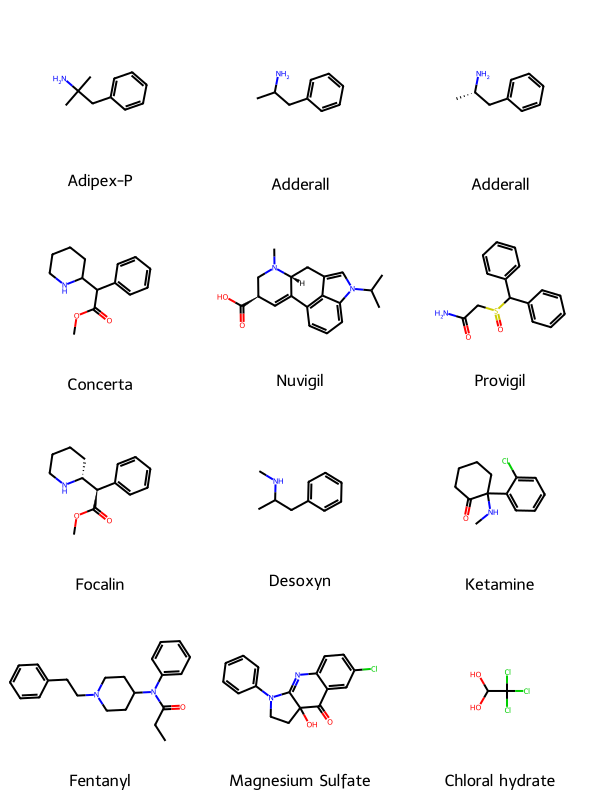

In [ ]:
Draw.MolsToGridImage(similar_drugs_df["cns_standardized_mol"], molsPerRow=3, subImgSize=(200,200), legends=similar_drugs_df["cns_drug"].tolist())

In [ ]:
# Function to query ChEMBL for protein targets using drug name
def get_targets_from_chembl_by_smiles(smiles):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule.json?smiles={smiles}"
    
    try:
        response = requests.get(url, timeout=10)  # Set timeout to avoid hanging requests
        if response.status_code == 200 and response.text.strip():
            data = response.json()
            if 'molecules' in data and data['molecules']:
                chembl_id = data['molecules'][0]['molecule_chembl_id']
                target_url = f"https://www.ebi.ac.uk/chembl/api/data/activity.json?molecule_chembl_id={chembl_id}"
                
                target_response = requests.get(target_url, timeout=10)
                if target_response.status_code == 200 and target_response.text.strip():
                    target_data = target_response.json()
                    if 'activities' in target_data:
                        targets = {
                            act['target_chembl_id']: act.get('target_pref_name', 'Unknown Target')
                            for act in target_data['activities']
                        }
                        return targets
        return {}  # Return empty if no targets found
    except requests.exceptions.RequestException as e:
        print(f"Error querying ChEMBL for {smiles}: {e}")
        return {}


# Store targets
cns_targets = {}
alz_targets = {}

for idx, row in similar_drugs_df.iterrows():
    cns_drug = row['cns_drug']
    alz_drug = row['alz_drug']
    cns_smiles = row['cns_smiles']
    alz_smiles = row['alz_smiles']

    # Query ChEMBL using Drug Name instead of SMILES
    if cns_drug not in cns_targets:
        print(f"Querying ChEMBL for CNS drug: {cns_drug}")
        cns_targets[cns_drug] = get_targets_from_chembl_by_smiles(cns_smiles)

    if alz_drug not in alz_targets:
        print(f"Querying ChEMBL for ALZ drug: {alz_drug}")
        alz_targets[alz_drug] = get_targets_from_chembl_by_smiles(alz_smiles)

# Add targets to the dataframe
similar_drugs_df['cns_targets'] = similar_drugs_df['cns_drug'].map(cns_targets)
similar_drugs_df['alz_targets'] = similar_drugs_df['alz_drug'].map(alz_targets)

Querying ChEMBL for CNS drug: Adipex-P
Querying ChEMBL for ALZ drug: 4-anisidine
Querying ChEMBL for CNS drug: Adderall
Querying ChEMBL for CNS drug: Concerta
Querying ChEMBL for CNS drug: Nuvigil
Querying ChEMBL for ALZ drug: Acetaminophen
Querying ChEMBL for CNS drug: Provigil
Querying ChEMBL for CNS drug: Focalin
Querying ChEMBL for CNS drug: Desoxyn
Querying ChEMBL for CNS drug: Ketamine
Querying ChEMBL for ALZ drug: 2-methoxy-5-(2',3',4'-trimethoxyphenyl)tropone
Querying ChEMBL for CNS drug: Fentanyl
Querying ChEMBL for CNS drug: Magnesium Sulfate
Querying ChEMBL for ALZ drug: 2,4,5,2',4',5'-hexachlorobiphenyl
Querying ChEMBL for CNS drug: Chloral hydrate
Querying ChEMBL for ALZ drug: Alendronate


In [ ]:
for each in similar_drugs_df['cns_targets']:

    print(each)

similar_drugs_df

{'CHEMBL5857': 'Trace amine-associated receptor 1', 'CHEMBL2039': 'Monoamine oxidase B', 'CHEMBL368': 'Trypanosoma cruzi', 'CHEMBL612348': 'Trypanosoma brucei rhodesiense', 'CHEMBL612851': 'Trypanosoma brucei brucei', 'CHEMBL612849': 'Trypanosoma brucei', 'CHEMBL612884': 'Trichomonas vaginalis', 'CHEMBL612888': 'Toxoplasma gondii', 'CHEMBL613064': 'Pneumocystis carinii', 'CHEMBL364': 'Plasmodium falciparum', 'CHEMBL3879801': 'NON-PROTEIN TARGET', 'CHEMBL612880': 'Leishmania mexicana', 'CHEMBL612879': 'Leishmania major', 'CHEMBL612848': 'Leishmania infantum', 'CHEMBL367': 'Leishmania donovani', 'CHEMBL612877': 'Leishmania amazonensis', 'CHEMBL612853': 'Entamoeba histolytica', 'CHEMBL612855': 'Cryptosporidium parvum', 'CHEMBL1626541': 'Phospholipidosis'}
{'CHEMBL375': 'Mus musculus', 'CHEMBL612558': 'ADMET', 'CHEMBL2094123': 'Serotonin (5-HT) receptor', 'CHEMBL2095159': 'Serotonin 1 (5-HT1) receptor', 'CHEMBL2093870': 'Serotonin 2 (5-HT2) receptor', 'CHEMBL376': 'Rattus norvegicus'}
{'CH

,cns_drug,cns_standardized_mol,cns_smiles,alz_drug,alz_standardized_mol,alz_smiles,tanimoto_similarity,cns_targets,alz_targets
0,Adipex-P,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(C)(N)Cc1ccccc1,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COc1ccc(N)cc1,0.206897,{'CHEMBL5857': 'Trace amine-associated recepto...,"{'CHEMBL612558': 'ADMET', 'CHEMBL2362975': 'No..."
1,Adderall,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(N)Cc1ccccc1,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COc1ccc(N)cc1,0.166667,"{'CHEMBL375': 'Mus musculus', 'CHEMBL612558': ...","{'CHEMBL612558': 'ADMET', 'CHEMBL2362975': 'No..."
2,Adderall,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,C[C@H](N)Cc1ccccc1,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COc1ccc(N)cc1,0.166667,"{'CHEMBL375': 'Mus musculus', 'CHEMBL612558': ...","{'CHEMBL612558': 'ADMET', 'CHEMBL2362975': 'No..."
3,Concerta,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,COC(=O)C(c1ccccc1)C1CCCCN1,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COc1ccc(N)cc1,0.181818,"{'CHEMBL375': 'Mus musculus', 'CHEMBL376': 'Ra...","{'CHEMBL612558': 'ADMET', 'CHEMBL2362975': 'No..."
4,Nuvigil,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CC(C)n1cc2c3c(cccc31)C1=C[C@@H](C(=O)O)CN(C)[C...,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)Nc1ccc(O)cc1,0.118644,{},"{'CHEMBL3253': 'Serum albumin', 'CHEMBL612558'..."
5,Provigil,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,NC(=O)CS(=O)C(c1ccccc1)c1ccccc1,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)Nc1ccc(O)cc1,0.153846,{},"{'CHEMBL3253': 'Serum albumin', 'CHEMBL612558'..."
6,Focalin,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,COC(=O)[C@H](c1ccccc1)[C@H]1CCCCN1,4-anisidine,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COc1ccc(N)cc1,0.181818,"{'CHEMBL338': 'Dopamine transporter', 'CHEMBL6...","{'CHEMBL612558': 'ADMET', 'CHEMBL2362975': 'No..."
7,Desoxyn,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CNC(C)Cc1ccccc1,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)Nc1ccc(O)cc1,0.142857,{'CHEMBL1893': 'Synaptic vesicular amine trans...,"{'CHEMBL3253': 'Serum albumin', 'CHEMBL612558'..."
8,Ketamine,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CNC1(c2ccccc2Cl)CCCCC1=O,"2-methoxy-5-(2',3',4'-trimethoxyphenyl)tropone",<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,COc1ccc(-c2ccc(OC)c(=O)cc2)c(OC)c1OC,0.134615,"{'CHEMBL1907608': 'Glutamate NMDA receptor', '...","{'CHEMBL2094134': 'Tubulin', 'CHEMBL612545': '..."
9,Fentanyl,<rdkit.Chem.rdchem.Mol object at 0x0000014F155...,CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1,Acetaminophen,<rdkit.Chem.rdchem.Mol object at 0x0000014F165...,CC(=O)Nc1ccc(O)cc1,0.137255,"{'CHEMBL375': 'Mus musculus', 'CHEMBL270': 'Mu...","{'CHEMBL3253': 'Serum albumin', 'CHEMBL612558'..."


In [ ]:
from tqdm import tqdm

alz_targets = {}

# Use tqdm for progress bar
for idx, row in tqdm(alz_df.iterrows(), total=len(alz_df), desc="Querying ChEMBL"):
    drug_name = row['Name']
    drug_smiles = row['SMILES']
    
    if drug_name not in alz_targets:
        alz_targets[drug_name] = get_targets_from_chembl_by_smiles(drug_smiles)

# Add targets to the dataframe
alz_df['targets'] = alz_df['Name'].map(alz_targets)


Querying ChEMBL: 100%|██████████| 1081/1081 [01:33<00:00, 11.56it/s]


In [ ]:
alz_non_empty_targets = alz_df[alz_df['targets'].apply(lambda x: bool(x))]
alz_non_empty_targets

,IPAD_DB_ID,Name,Targeting-protein,Research models,Ref. Link,Molecular Formula,Molecular Weight,IUPAC Name,InChI,InChI Key,...,TPSA,fingerprint_cluster,property_cluster,scaffold,scaffold_cluster,fingerprint_cluster_label,property_cluster_label,scaffold_cluster_label,label,targets
69,D00070,N-acetyl-L-cysteine,Aβ,In SHSY5Y neuroblastoma cell,https://doi.org/10.1046/j.1471-4159.2001.00090.x,C5H9NO3S,163.20 g/mol,(2R)-2-acetamido-3-sulfanylpropanoic acid,"InChI=1S/C5H9NO3S/c1-3(7)6-4(2-10)5(8)9/h4,10H...",PWKSKIMOESPYIA-BYPYZUCNSA-N,...,193.91,0,2,,0,Cluster 0 (355),Cluster 2 (71),Cluster 0 (231),1,"{'CHEMBL614078': 'MDA-N', 'CHEMBL614054': 'SN1..."
70,D00071,N-acetyl-L-cysteine,Tau protein,In SHSY5Y neuroblastoma cell,https://doi.org/10.1046/j.1471-4159.2001.00090.x,C5H9NO3S,163.20 g/mol,(2R)-2-acetamido-3-sulfanylpropanoic acid,"InChI=1S/C5H9NO3S/c1-3(7)6-4(2-10)5(8)9/h4,10H...",PWKSKIMOESPYIA-BYPYZUCNSA-N,...,112.73,0,4,,0,Cluster 0 (355),Cluster 4 (426),Cluster 0 (231),1,"{'CHEMBL614078': 'MDA-N', 'CHEMBL614054': 'SN1..."
330,D00331,1-Butanol,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/1497677/,C4H10O,74.12,butan-1-ol,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3",LRHPLDYGYMQRHN-UHFFFAOYSA-N,...,44.76,0,1,,0,Cluster 0 (355),Cluster 1 (349),Cluster 0 (231),1,"{'CHEMBL3945': 'Choline acetylase', 'CHEMBL236..."
331,D00332,1-Butanol,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/12192006/,C4H10O,74.12,butan-1-ol,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3",LRHPLDYGYMQRHN-UHFFFAOYSA-N,...,44.76,0,1,,0,Cluster 0 (355),Cluster 1 (349),Cluster 0 (231),1,"{'CHEMBL3945': 'Choline acetylase', 'CHEMBL236..."
332,D00333,1-Butanol,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/12572668/,C4H10O,74.12,butan-1-ol,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3",LRHPLDYGYMQRHN-UHFFFAOYSA-N,...,42.68,0,1,,0,Cluster 0 (355),Cluster 1 (349),Cluster 0 (231),1,"{'CHEMBL3945': 'Choline acetylase', 'CHEMBL236..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,D01153,Acrolein,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/15993441/,C3H4O,56.06,prop-2-enal,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",HGINCPLSRVDWNT-UHFFFAOYSA-N,...,0.00,1,4,,0,Cluster 1 (23),Cluster 4 (426),Cluster 0 (231),1,"{'CHEMBL613853': 'CHO', 'CHEMBL614556': 'CHO-F..."
1153,D01154,Acrolein,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/16204253/,C3H4O,56.06,prop-2-enal,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",HGINCPLSRVDWNT-UHFFFAOYSA-N,...,0.00,1,3,,0,Cluster 1 (23),Cluster 3 (113),Cluster 0 (231),1,"{'CHEMBL613853': 'CHO', 'CHEMBL614556': 'CHO-F..."
1154,D01155,Acrolein,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/16266835/,C3H4O,56.06,prop-2-enal,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",HGINCPLSRVDWNT-UHFFFAOYSA-N,...,0.00,1,3,,0,Cluster 1 (23),Cluster 3 (113),Cluster 0 (231),1,"{'CHEMBL613853': 'CHO', 'CHEMBL614556': 'CHO-F..."
1155,D01156,Acrolein,Aβ,-,https://pubmed.ncbi.nlm.nih.gov/16325427/,C3H4O,56.06,prop-2-enal,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",HGINCPLSRVDWNT-UHFFFAOYSA-N,...,29.46,1,0,,0,Cluster 1 (23),Cluster 0 (104),Cluster 0 (231),1,"{'CHEMBL613853': 'CHO', 'CHEMBL614556': 'CHO-F..."


In [ ]:
# Create a mapping of targets to their respective drugs in both datasets
cns_target_to_drug = {}
for _, row in similar_drugs_df.dropna(subset=['cns_targets']).iterrows():
    for target in row['cns_targets'].keys():
        if target not in cns_target_to_drug:
            cns_target_to_drug[target] = set()
        cns_target_to_drug[target].add(row['cns_drug'])

alz_target_to_drug = {}
for _, row in alz_non_empty_targets.dropna(subset=['targets']).iterrows():
    for target in row['targets'].keys():
        if target not in alz_target_to_drug:
            alz_target_to_drug[target] = set()
        alz_target_to_drug[target].add(row['Name'])

# Create a list of tuples for the final dataframe
common_targets_data = []
for target in common_targets_list:
    cns_drugs = ", ".join(cns_target_to_drug.get(target, []))
    alz_drugs = ", ".join(alz_target_to_drug.get(target, []))
    common_targets_data.append((target, cns_drugs, alz_drugs))

# Convert to a DataFrame
common_targets_df = pd.DataFrame(common_targets_data, columns=['Common Targets', 'CNS Drugs', 'Alzheimers Drugs'])

In [ ]:

def get_target_info(chembl_id):
    """Fetch target details from ChEMBL API using a ChEMBL Target ID."""
    url = f"https://www.ebi.ac.uk/chembl/api/data/target/{chembl_id}.json"
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Extract relevant details safely
        target_components = data.get("target_components", [])
        classification = target_components[0].get("protein_classifications", "N/A") if target_components else "N/A"
        components = [comp.get("component_type", "N/A") for comp in target_components] if target_components else ["N/A"]

        target_info = {
            "ChEMBL_ID": chembl_id,
            "Target_Name": data.get("pref_name", "N/A"),
            "Target_Type": data.get("target_type", "N/A"),
            "Organism": data.get("organism", "N/A"),
            "Classification": classification,
            "Components": components
        }
        return target_info

    except requests.exceptions.RequestException as e:
        print(f"Error fetching target {chembl_id}: {e}")
        return {"ChEMBL_ID": chembl_id, "Error": str(e)}

# Example ChEMBL Target IDs
chembl_targets = [
    "CHEMBL614818", "CHEMBL376", "CHEMBL2362975",
    "CHEMBL3681", "CHEMBL2439", "CHEMBL374",
    "CHEMBL612545", "CHEMBL612558", "CHEMBL375"
]

# Retrieve data for all targets
target_data = [get_target_info(target) for target in chembl_targets]

# Convert to DataFrame and display
df_targets = pd.DataFrame(target_data)



In [ ]:
merged_df = common_targets_df.merge(df_targets, 
                                    left_on="Common Targets", 
                                    right_on="ChEMBL_ID", 
                                    how="left")
merged_df

,Common Targets,CNS Drugs,Alzheimers Drugs,ChEMBL_ID,Target_Name,Target_Type,Organism,Classification,Components
0,CHEMBL614818,Desoxyn,Acetylcholine,CHEMBL614818,HEK293,CELL-LINE,Homo sapiens,N/A,[N/A]
1,CHEMBL376,"Focalin, Fentanyl, Adderall, Concerta, Ketamine","Aceclidine, Acrolein",CHEMBL376,Rattus norvegicus,ORGANISM,Rattus norvegicus,N/A,[N/A]
2,CHEMBL2362975,Ketamine,"1-Butanol, 2-ethoxyethanol",CHEMBL2362975,No relevant target,NO TARGET,None,N/A,[N/A]
3,CHEMBL3681,Chloral hydrate,Acrolein,CHEMBL3681,Monoamine oxidase A,SINGLE PROTEIN,Mus musculus,N/A,[PROTEIN]
4,CHEMBL2439,Chloral hydrate,Acetaldehyde,CHEMBL2439,Myeloperoxidase,SINGLE PROTEIN,Homo sapiens,N/A,[PROTEIN]
5,CHEMBL374,Fentanyl,1-Butanol,CHEMBL374,Oryctolagus cuniculus,ORGANISM,Oryctolagus cuniculus,N/A,[N/A]
6,CHEMBL612545,"Chloral hydrate, Concerta, Focalin",Aceclidine,CHEMBL612545,Unchecked,UNCHECKED,None,N/A,[N/A]
7,CHEMBL612558,"Adderall, Ketamine","Acetaldehyde, 1-Butanol",CHEMBL612558,ADMET,ADMET,None,N/A,[N/A]
8,CHEMBL375,"Adderall, Concerta, Ketamine, Fentanyl",Aceclidine,CHEMBL375,Mus musculus,ORGANISM,Mus musculus,N/A,[N/A]


Monoamine oxidase A

Chloral hydrate

Acrolein

In [ ]:
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

In [ ]:
protein_pdbqt = "2z5x.pdb"

# Visualize docking results
view = py3Dmol.view(width=800, height=600)
view.addModel(open("2z5x.pdb").read(), "pdb")  # Protein structure
for name in ligands.keys():
    view.addModel(open(f"{name}_docked.pdbqt").read(), "pdb")  # Ligand docked structure
view.setStyle({"cartoon": {"color": "spectrum"}})
view.zoomTo()
view.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Chloral_Hydrate_docking.log'